In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split

### Loading Data

In [2]:
data = np.load("processed_data_15mb.npy")
data[0]

array([223.42572149,  11.2162412 , 142.91931267, -10.64358875,
       -67.87036543,  22.16435136, -14.075186  , -53.04049885,
        10.7013447 ,  64.19134658,  15.47206643,  50.2422    ,
         1.        ])

In [3]:
x = data[:, :-1]
y = np.array(data[:, -1], dtype=int)

### Train-Test-Validation
Shuffling and dividing the data as follows:
* Training : 70%
* Validation : 15%
* Testing : 15%

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5)

In [5]:
d_train = xgb.DMatrix(x_train, label=y_train)
d_val = xgb.DMatrix(x_val, label=y_val)
d_test = xgb.DMatrix(x_test, label=y_test)

### Model Training

In [6]:
param = {
    # max depth of the tree
    "max_depth": 3,
    # step size shrinkage
    "eta": 0.3,
    # silent parameter
    "silent": 0,
    # objective -> binary classification
    "objective": "binary:logistic",
    # number of threads
    "nthread": 7,
    # evaluation criterion
    "eval_metric": "logloss"
}

In [7]:
eval_list = [(d_train, "train"), (d_test, "eval")]

In [8]:
num_round = 100
bst100 = xgb.train(param, d_train, num_round, eval_list, verbose_eval=False)

In [9]:
num_round = 1000
bst1000 = xgb.train(param, d_train, num_round, eval_list, verbose_eval=False)

### Feature Importance

In [10]:
feature_map = {
    "f0": "Eigen projection 1",
    "f1": "Eigen projection 2",
    "f2": "Eigen projection 3",
    "f3": "Eigen projection 4",
    "f4": "Eigen projection 5",
    "f5": "Eigen projection 6",
    "f6": "Eigen projection 7",
    "f7": "Eigen projection 8",
    "f8": "Eigen projection 9",
    "f9": "Eigen projection 10",
    "f10": "RMSE",
    "f11": "Peak2Peak"
}

In [11]:
def visualize_features(bst, feature_map=None):
    xgb.plot_importance(bst)
    plt.show()
    if feature_map:
        print("Feature Map : ")
        for x in feature_map:
            print(x, "\t: ", feature_map[x])

100 Iterations


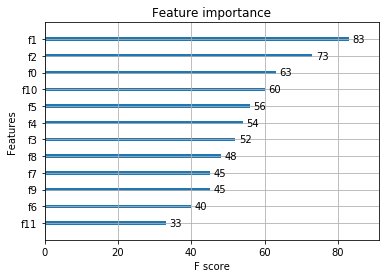

Feature Map : 
f0 	:  Eigen projection 1
f1 	:  Eigen projection 2
f2 	:  Eigen projection 3
f3 	:  Eigen projection 4
f4 	:  Eigen projection 5
f5 	:  Eigen projection 6
f6 	:  Eigen projection 7
f7 	:  Eigen projection 8
f8 	:  Eigen projection 9
f9 	:  Eigen projection 10
f10 	:  RMSE
f11 	:  Peak2Peak


In [12]:
print("100 Iterations")
visualize_features(bst100, feature_map)

1000 Iterations


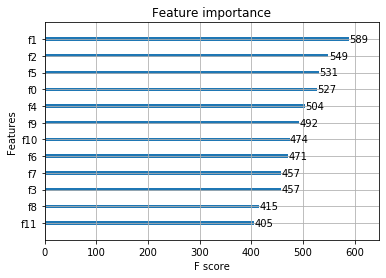

Feature Map : 
f0 	:  Eigen projection 1
f1 	:  Eigen projection 2
f2 	:  Eigen projection 3
f3 	:  Eigen projection 4
f4 	:  Eigen projection 5
f5 	:  Eigen projection 6
f6 	:  Eigen projection 7
f7 	:  Eigen projection 8
f8 	:  Eigen projection 9
f9 	:  Eigen projection 10
f10 	:  RMSE
f11 	:  Peak2Peak


In [13]:
print("1000 Iterations")
visualize_features(bst1000, feature_map)

### Margin Plots on Test Data

In [19]:
y_pred_1000 = bst1000.predict(d_test, ntree_limit=bst1000.best_ntree_limit, output_margin=True)
y_test = d_test.get_label()

In [23]:
def get_error_values(y_pred, y_test, thresholds):
    accuracy_1 = []
    accuracy_0 = []
    for thresh in thresholds:
        y_test_i = y_test[y_test == 1]
        y_pred_i = y_pred[y_test == 1]
        correct = np.sum(y_pred_i > thresh)
        accuracy_1.append(1.0 * correct / len(y_test_i))
        y_test_i = y_test[y_test == 0]
        y_pred_i = y_pred[y_test == 0]
        correct = np.sum(y_pred_i <= thresh)
        accuracy_0.append(1.0 * correct / len(y_test_i))
    error_1 = list(1 - np.array(accuracy_1))
    error_0 = list(1 - np.array(accuracy_0))
    return error_1, error_0

In [24]:
def get_margin_plot(error_1, error_0, thresholds, legends = None, title=None, style=['b', 'r']):
    plt.plot(thresholds/(np.max(thresholds) - np.min(thresholds)), error_1, style[0])
    plt.plot(thresholds/(np.max(thresholds) - np.min(thresholds)), error_0, style[1])
    if legends:
        plt.legend(legends)
    plt.xlabel('Margin Score')
    plt.ylabel('Error %')
    if title:
        plt.title(title)

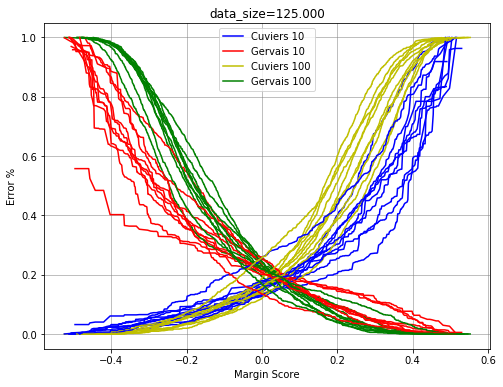

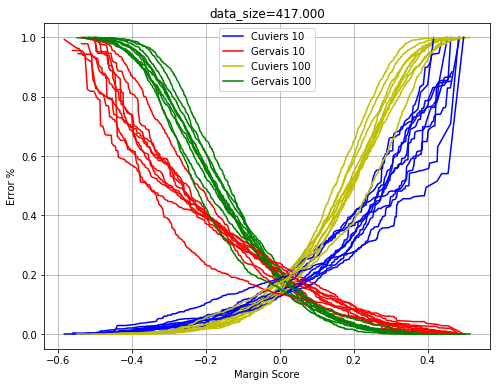

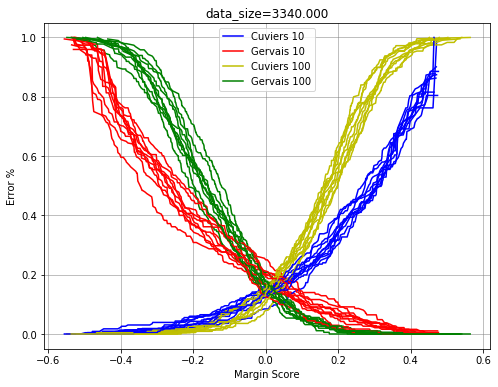

In [28]:
num_round = 10
for _train_size in [0.03, 0.1, 0.8]:
    plt.figure(figsize=(8, 6))
    for i in range(10):
        x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=_train_size, test_size=1-_train_size)
        x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5)
        d_train = xgb.DMatrix(x_train, label=y_train)
        d_test = xgb.DMatrix(x_test, label=y_test)
        d_val = xgb.DMatrix(x_val, label=y_val)
        
        legends=[]
        for num_round in [10, 100]:
            bst = xgb.train(param, d_train, num_round, eval_list, verbose_eval=False)
            y_pred = bst.predict(d_test, ntree_limit=bst.best_ntree_limit, output_margin=True)
            thresholds = sorted(np.unique(np.round(y_pred, 2)))
            error_cuv, error_ger = get_error_values(y_pred, y_test, thresholds)
            legends += ['Cuviers %d'%num_round, 'Gervais %d'%num_round]
            _style=['y','g'] if num_round==100 else ['b', 'r']
            get_margin_plot(error_cuv, error_ger, thresholds, legends = legends, style=_style)
        
        plt.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
        plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
        thr = thresholds/(np.max(thresholds) - np.min(thresholds))
    plt.title('data_size=%4.3f'%(x_train.shape[0]))
    plt.show()